In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import pickle
import os
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # return fig


def log(msg):
    print(msg, '\n')


def createFolders():
    os.mkdir('./breeds/train/')
    os.mkdir('./species/train/')
    os.mkdir('./breeds/test/')
    os.mkdir('./species/test/')
    for breed in list(classDic.keys()):
        # Breeds
        trainPath = os.path.join('./breeds/train/' + breed)
        if not os.path.exists(trainPath):
            os.mkdir('./breeds/train/' + breed)

        testPath = os.path.join('./breeds/test/' + breed)
        if not os.path.exists(testPath):
            os.mkdir('./breeds/test/' + breed)

        # Dogs
        trainPath = os.path.join('./species/train/dog')
        if not os.path.exists(trainPath):
            os.mkdir('./species/train/dog')

        testPath = os.path.join('./species/test/dog')
        if not os.path.exists(testPath):
            os.mkdir('./species/test/dog')

        # Cats
        trainPath = os.path.join('./species/train/cat')
        if not os.path.exists(trainPath):
            os.mkdir('./species/train/cat')

        testPath = os.path.join('./species/test/cat')
        if not os.path.exists(testPath):
            os.mkdir('./species/test/cat')


def splitBreeds():
    for imgName in list(filesDic.keys()):
        img = keras.preprocessing.image.load_img('images/' + imgName)
        foldTrain = filesDic.get(imgName).get('foldTrain')

        keras.preprocessing.image.save_img(
            './breeds/' + ('train/' if foldTrain else 'test/') + filesDic.get(imgName).get('breed') + '/' + imgName, img)


def splitSpecies():
    for imgName in list(filesDic.keys()):
        img = keras.preprocessing.image.load_img('images/' + imgName)
        foldTrain = filesDic.get(imgName).get('foldTrain')

        keras.preprocessing.image.save_img(
            './species/' + ('train/' if foldTrain else 'test/') + filesDic.get(imgName).get('species') + '/' + imgName, img)


D = dict(pickle.load(open('Oxford-IIIT-Pet_Dics.p', 'rb')))
# log(D)
imageNum = 7390

DKeys = list(D.keys())
# log(DKeys)

classDic = dict(D.get('classDic'))
# log(classDic)

filesDic = dict(D.get('filesDic'))
# log(list(filesDic.keys()))
filesDicValues = list(filesDic.values())
# log(filesDicValues[-1:])

# UNCOMMENT THE FOLLOWING TO REHIERARCHIZE THE DATA:
# createFolders()
# splitBreeds()
# splitSpecies()


To prepare the dataset, we restructered the the way the .jpg files are hierarchized.

Instead of trowing everything into a folder named "/images", we opted to create a "/breeds" and "/species" folder, each one with children folders named "/train" and "/test". For the breeds, the images are organized in multiple folders for each specific breed. For the species, there are only 2 folders to organize images, cats and dogs.

This process will make it much easier to implement the next phases of the projet.

# CNN network from scratch

In [5]:
speciesCnn = models.Sequential()

speciesCnn.add(layers.Conv2D(6, (5, 5), activation='relu',
                             input_shape=(224, 224, 3), padding="same"))
speciesCnn.add(layers.AveragePooling2D((2, 2)))
speciesCnn.add(layers.Conv2D(16, (5, 5), activation='relu'))
speciesCnn.add(layers.AveragePooling2D((2, 2)))
speciesCnn.add(layers.Conv2D(120, (1, 1), activation='relu'))
speciesCnn.add(layers.Flatten())
speciesCnn.add(layers.Dense(64, activation='relu'))
speciesCnn.add(layers.Dense(2, activation='softmax'))  # 2 species

speciesCnn.summary()

speciesCnn.compile(optimizer="nadam",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 120)       2040      
_________________________________________________________________
flatten (Flatten)            (None, 349920)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

We can see that the network has a parameters total of 22,399,986, which is quite a lot compared to the pre-trained network we'll be using.

In [6]:
breedsCnn = models.Sequential()

breedsCnn.add(layers.Conv2D(6, (5, 5), activation='relu',
                            input_shape=(224, 224, 3), padding="same"))
breedsCnn.add(layers.AveragePooling2D((2, 2)))
breedsCnn.add(layers.Conv2D(16, (5, 5), activation='relu'))
breedsCnn.add(layers.AveragePooling2D((2, 2)))
breedsCnn.add(layers.Conv2D(120, (1, 1), activation='relu'))
breedsCnn.add(layers.Flatten())
breedsCnn.add(layers.Dense(64, activation='relu'))
breedsCnn.add(layers.Dense(37, activation='softmax'))  # 37 breeds

breedsCnn.summary()

breedsCnn.compile(optimizer="nadam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 6)       456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 108, 108, 16)      2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 54, 54, 120)       2040      
_________________________________________________________________
flatten_1 (Flatten)          (None, 349920)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

We're using an input size of 224x224 because it seems like a good shape for the overall images, but mostly because it's compatible with the MobileNetV2 pre-trained network.

# Pre trained network

In [7]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

mn2 = MobileNetV2(weights='imagenet',
                  input_shape=(224, 224, 3))

mn2.trainable = False

# mn2.summary()

breedsMn2Cnn = models.Sequential()
breedsMn2Cnn.add(mn2)
breedsMn2Cnn.add(layers.Flatten())
breedsMn2Cnn.add(layers.Dense(37, activation='softmax'))  # 37 breeds

breedsMn2Cnn.summary()

breedsMn2Cnn.compile(optimizer="nadam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1000)              3538984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 37)                37037     
Total params: 3,576,021
Trainable params: 37,037
Non-trainable params: 3,538,984
_________________________________________________________________


We have chosen the mobileNetV2 because it's a network that has aproximmately 3.5M parameters and makes it quick for us to train, compared to other networks. It has much less parameters than the previous network. At the same time, it's one of Keras Applications that has the fewer parameters as we see in https://keras.io/api/applications/.

# Data generator with and without data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

breedsDir = './breeds/'

breedsGen = ImageDataGenerator(preprocessing_function=preprocess_input)

breedsGenAug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

breedsTrainGen = breedsGen.flow_from_directory(directory=breedsDir + "train/",
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               batch_size=32)

breedsTrainGenAug = breedsGenAug.flow_from_directory(directory=breedsDir + "train/",
                                                     target_size=(224, 224),
                                                     class_mode="categorical",
                                                     batch_size=32)

breedsTestGen = breedsGen.flow_from_directory(directory=breedsDir + "test/",
                                              target_size=(224, 224),
                                              class_mode="categorical",
                                              batch_size=32)

speciesDir = './species/'

speciesGen = ImageDataGenerator(preprocessing_function=preprocess_input)

speciesGenAug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

speciesTrainGen = speciesGen.flow_from_directory(directory=speciesDir + "train/",
                                                 target_size=(224, 224),
                                                 class_mode="categorical",
                                                 batch_size=32)

speciesTrainGenAug = speciesGenAug.flow_from_directory(directory=speciesDir + "train/",
                                                       target_size=(224, 224),
                                                       class_mode="categorical",
                                                       batch_size=32)

speciesTestGen = speciesGen.flow_from_directory(directory=speciesDir + "test/",
                                                target_size=(224, 224),
                                                class_mode="categorical",
                                                batch_size=32)


Found 3686 images belonging to 37 classes.
Found 3686 images belonging to 37 classes.
Found 3704 images belonging to 37 classes.
Found 3686 images belonging to 2 classes.
Found 3686 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.


We didn't augment the data for the test set. If we were to use validation data, we wouldn't use data augmentation either.

Loading the images with the Keras image generators, specifying a predefined dimension (height and width), we introduce a new problem: The fact that we are resizing the images, results in distortions that vary with the original size of the image. To deal with such a problem, there are techniques available online to minimize the distortion and noise originated by the image resizing. Most of those techniques consist of gathering images in batches with similar dimensions and creatign a preprocessing function from scratch that handles those different batches. The whole process is explained in this link: https://medium.com/softmax/keras-data-generator-for-images-of-different-dimensions-9ff82f6fab03

Due to shortage of time, we weren't able to explore those possibilities.

In [9]:
epochs = 25


# Binary (Species)

## Without data augmentation

Train for 116 steps, validate for 116 steps
Epoch 1/25
116/116 [==============================] - 134s 1s/step - loss: 0.7533 - accuracy: 0.6715 - val_loss: 0.6065 - val_accuracy: 0.6822
Epoch 2/25
116/116 [==============================] - 111s 955ms/step - loss: 0.5383 - accuracy: 0.7254 - val_loss: 0.5456 - val_accuracy: 0.7176
Epoch 3/25
116/116 [==============================] - 116s 1s/step - loss: 0.4348 - accuracy: 0.8022 - val_loss: 0.5823 - val_accuracy: 0.7095
Epoch 4/25
116/116 [==============================] - 110s 952ms/step - loss: 0.2656 - accuracy: 0.8904 - val_loss: 0.6928 - val_accuracy: 0.7071
Epoch 5/25
116/116 [==============================] - 110s 948ms/step - loss: 0.1158 - accuracy: 0.9615 - val_loss: 0.9260 - val_accuracy: 0.7100
Epoch 6/25
116/116 [==============================] - 115s 995ms/step - loss: 0.0647 - accuracy: 0.9848 - val_loss: 1.1505 - val_accuracy: 0.6849
Epoch 7/25
116/116 [==============================] - 112s 968ms/step - loss: 0.0244 -

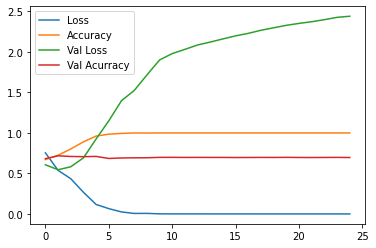

In [10]:
log = speciesCnn.fit(speciesTrainGen,
                     epochs=epochs,
                     validation_data=speciesTestGen)

h = log.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Acurracy')
plt.legend()
plt.show()

predicted = speciesCnn.predict(speciesTestGen)


Number of erros: 1620
Confusion matrix, without normalization


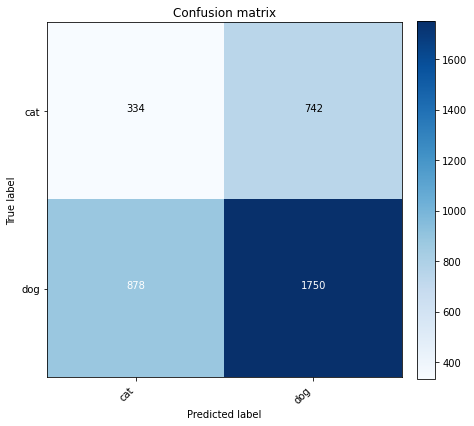

In [11]:
p = np.argmax(predicted, axis=1)

print('Number of erros:', np.sum(p != speciesTestGen.classes))

plot_confusion_matrix(confusion_matrix(p, speciesTestGen.classes),
                      classes=speciesTestGen.class_indices.keys())


## With data augmentation

Train for 116 steps, validate for 116 steps
Epoch 1/25
116/116 [==============================] - 142s 1s/step - loss: 0.8547 - accuracy: 0.6712 - val_loss: 0.6288 - val_accuracy: 0.6725
Epoch 2/25
116/116 [==============================] - 134s 1s/step - loss: 0.6095 - accuracy: 0.6780 - val_loss: 0.5968 - val_accuracy: 0.6731
Epoch 3/25
116/116 [==============================] - 133s 1s/step - loss: 0.5996 - accuracy: 0.6801 - val_loss: 0.5894 - val_accuracy: 0.6801
Epoch 4/25
116/116 [==============================] - 134s 1s/step - loss: 0.5879 - accuracy: 0.6896 - val_loss: 0.5706 - val_accuracy: 0.6914
Epoch 5/25
116/116 [==============================] - 134s 1s/step - loss: 0.5877 - accuracy: 0.6867 - val_loss: 0.5821 - val_accuracy: 0.6890
Epoch 6/25
116/116 [==============================] - 134s 1s/step - loss: 0.5850 - accuracy: 0.6848 - val_loss: 0.7128 - val_accuracy: 0.6755
Epoch 7/25
116/116 [==============================] - 134s 1s/step - loss: 0.5796 - accuracy: 0.69

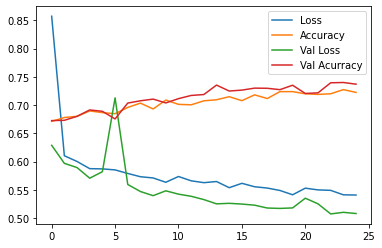

In [12]:
log = speciesCnn.fit(speciesTrainGenAug,
                     epochs=epochs,
                     validation_data=speciesTestGen)

h = log.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Acurracy')
plt.legend()
plt.show()

predicted = speciesCnn.predict(speciesTestGen)


Number of erros: 1402
Confusion matrix, without normalization


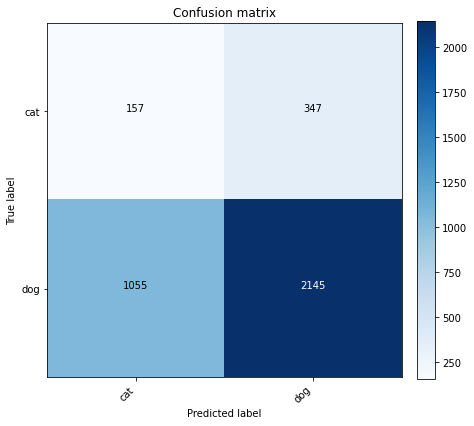

In [13]:
p = np.argmax(predicted, axis=1)

print('Number of erros:', np.sum(p != speciesTestGen.classes))

plot_confusion_matrix(confusion_matrix(p, speciesTestGen.classes),
                      classes=speciesTestGen.class_indices.keys())


We can see that with data augmentation we get slightly better results, and a confusion matrix with less errors.

# Multi-class (Breeds)

## Without data augmentation

### Scratch network

Train for 116 steps, validate for 116 steps
Epoch 1/25
116/116 [==============================] - 113s 977ms/step - loss: 3.8170 - accuracy: 0.0448 - val_loss: 3.5457 - val_accuracy: 0.0586
Epoch 2/25
116/116 [==============================] - 95s 818ms/step - loss: 3.4073 - accuracy: 0.0882 - val_loss: 3.4157 - val_accuracy: 0.0875
Epoch 3/25
116/116 [==============================] - 96s 827ms/step - loss: 2.9116 - accuracy: 0.2073 - val_loss: 3.4673 - val_accuracy: 0.1002
Epoch 4/25
116/116 [==============================] - 95s 819ms/step - loss: 1.9474 - accuracy: 0.4471 - val_loss: 3.9949 - val_accuracy: 0.1045
Epoch 5/25
116/116 [==============================] - 96s 826ms/step - loss: 0.8083 - accuracy: 0.7651 - val_loss: 5.7952 - val_accuracy: 0.0948
Epoch 6/25
116/116 [==============================] - 95s 821ms/step - loss: 0.2518 - accuracy: 0.9319 - val_loss: 7.4297 - val_accuracy: 0.0937
Epoch 7/25
116/116 [==============================] - 96s 828ms/step - loss: 0.0941 -

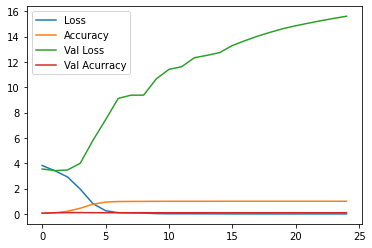

In [14]:
log = breedsCnn.fit(breedsTrainGen,
                    epochs=epochs,
                    validation_data=breedsTestGen)

h = log.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Acurracy')
plt.legend()
plt.show()

predicted = breedsCnn.predict(breedsTestGen)


Number of erros: 3620
Confusion matrix, without normalization


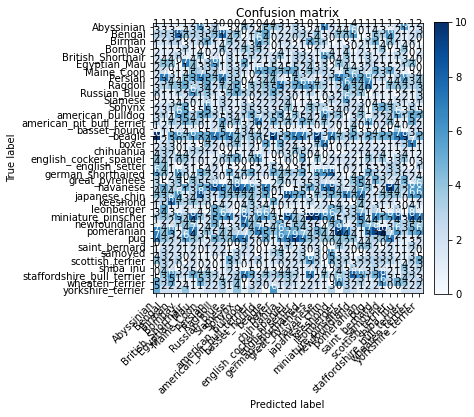

In [15]:
p = np.argmax(predicted, axis=1)

print('Number of erros:', np.sum(p != breedsTestGen.classes))

plot_confusion_matrix(confusion_matrix(p, breedsTestGen.classes),
                      classes=breedsTestGen.class_indices.keys())


### MobileNetV2 network

Train for 116 steps, validate for 116 steps
Epoch 1/25
116/116 [==============================] - 231s 2s/step - loss: 3.5898 - accuracy: 0.2086 - val_loss: 3.5240 - val_accuracy: 0.4717
Epoch 2/25
116/116 [==============================] - 229s 2s/step - loss: 3.5390 - accuracy: 0.4973 - val_loss: 3.4339 - val_accuracy: 0.6668
Epoch 3/25
116/116 [==============================] - 228s 2s/step - loss: 3.4885 - accuracy: 0.6015 - val_loss: 3.3451 - val_accuracy: 0.7017
Epoch 4/25
116/116 [==============================] - 228s 2s/step - loss: 3.4384 - accuracy: 0.6443 - val_loss: 3.2575 - val_accuracy: 0.7419
Epoch 5/25
116/116 [==============================] - 227s 2s/step - loss: 3.3889 - accuracy: 0.6812 - val_loss: 3.1710 - val_accuracy: 0.7457
Epoch 6/25
116/116 [==============================] - 228s 2s/step - loss: 3.3399 - accuracy: 0.6853 - val_loss: 3.0860 - val_accuracy: 0.7484
Epoch 7/25
116/116 [==============================] - 229s 2s/step - loss: 3.2914 - accuracy: 0.69

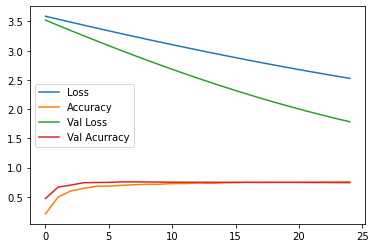

In [16]:
log = breedsMn2Cnn.fit(breedsTrainGen,
                       epochs=epochs,
                       validation_data=breedsTestGen)

h = log.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Acurracy')
plt.legend()
plt.show()

predicted = breedsMn2Cnn.predict(breedsTestGen)


Number of erros: 3605
Confusion matrix, without normalization


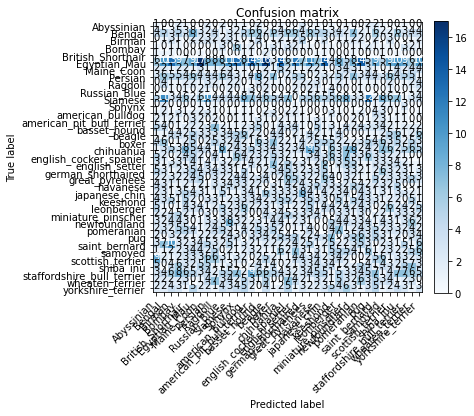

In [17]:
p = np.argmax(predicted, axis=1)

print('Number of erros:', np.sum(p != breedsTestGen.classes))

plot_confusion_matrix(confusion_matrix(p, breedsTestGen.classes),
                      classes=breedsTestGen.class_indices.keys())


Based on the graphics we see that our scratch network isn't well defined, resulting in really poor results.
On the other hand, using the predefined network, we reach some val_accuracy of 0.7, even though it results in a poor confusion matrix.

# Multi-class (Breeds)

## With data augmentation

### Scratch network

Train for 116 steps, validate for 116 steps
Epoch 1/25
116/116 [==============================] - 130s 1s/step - loss: 4.0937 - accuracy: 0.0477 - val_loss: 3.4785 - val_accuracy: 0.0710
Epoch 2/25
116/116 [==============================] - 130s 1s/step - loss: 3.4779 - accuracy: 0.0657 - val_loss: 3.4008 - val_accuracy: 0.0761
Epoch 3/25
116/116 [==============================] - 128s 1s/step - loss: 3.4012 - accuracy: 0.0795 - val_loss: 3.2770 - val_accuracy: 0.1099
Epoch 4/25
116/116 [==============================] - 128s 1s/step - loss: 3.3394 - accuracy: 0.0939 - val_loss: 3.2405 - val_accuracy: 0.1164
Epoch 5/25
116/116 [==============================] - 128s 1s/step - loss: 3.2915 - accuracy: 0.1126 - val_loss: 3.1994 - val_accuracy: 0.1156
Epoch 6/25
116/116 [==============================] - 128s 1s/step - loss: 3.2291 - accuracy: 0.1202 - val_loss: 3.2290 - val_accuracy: 0.1199
Epoch 7/25
116/116 [==============================] - 128s 1s/step - loss: 3.2117 - accuracy: 0.12

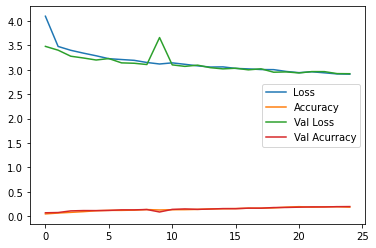

In [18]:
log = breedsCnn.fit(breedsTrainGenAug,
                    epochs=epochs,
                    validation_data=breedsTestGen)

h = log.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Acurracy')
plt.legend()
plt.show()

predicted = breedsCnn.predict(breedsTestGen)


Number of erros: 3598
Confusion matrix, without normalization


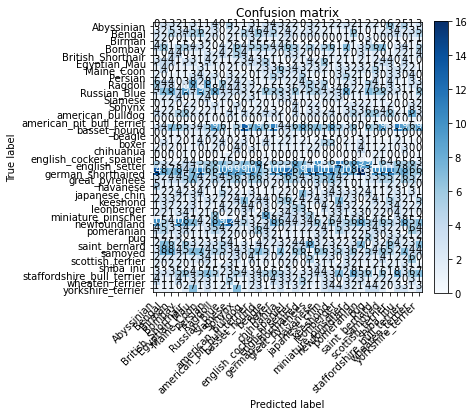

In [19]:
p = np.argmax(predicted, axis=1)

print('Number of erros:', np.sum(p != breedsTestGen.classes))

plot_confusion_matrix(confusion_matrix(p, breedsTestGen.classes),
                      classes=breedsTestGen.class_indices.keys())


### MobileNetV2 network

Train for 116 steps, validate for 116 steps
Epoch 1/25
116/116 [==============================] - 284s 2s/step - loss: 2.7342 - accuracy: 0.6484 - val_loss: 1.7463 - val_accuracy: 0.7424
Epoch 2/25
116/116 [==============================] - 277s 2s/step - loss: 2.6972 - accuracy: 0.6652 - val_loss: 1.7081 - val_accuracy: 0.7414
Epoch 3/25
116/116 [==============================] - 275s 2s/step - loss: 2.6796 - accuracy: 0.6677 - val_loss: 1.6712 - val_accuracy: 0.7422
Epoch 4/25
116/116 [==============================] - 277s 2s/step - loss: 2.6525 - accuracy: 0.6731 - val_loss: 1.6352 - val_accuracy: 0.7414
Epoch 5/25
116/116 [==============================] - 277s 2s/step - loss: 2.6430 - accuracy: 0.6804 - val_loss: 1.6009 - val_accuracy: 0.7406
Epoch 6/25
116/116 [==============================] - 283s 2s/step - loss: 2.5995 - accuracy: 0.6818 - val_loss: 1.5662 - val_accuracy: 0.7406
Epoch 7/25
116/116 [==============================] - 294s 3s/step - loss: 2.5828 - accuracy: 0.67

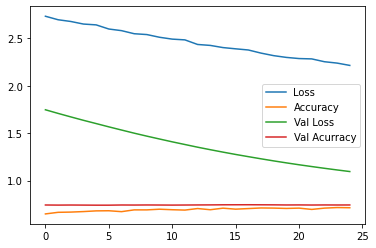

In [20]:
log = breedsMn2Cnn.fit(breedsTrainGenAug,
                       epochs=epochs,
                       validation_data=breedsTestGen)

h = log.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Acurracy')
plt.legend()
plt.show()

predicted = breedsMn2Cnn.predict(breedsTestGen)


Number of erros: 3602
Confusion matrix, without normalization


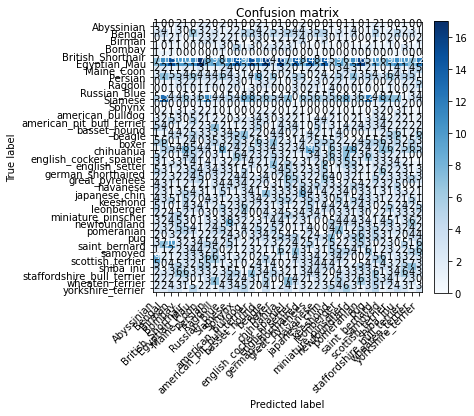

In [21]:
p = np.argmax(predicted, axis=1)

print('Number of erros:', np.sum(p != breedsTestGen.classes))

plot_confusion_matrix(confusion_matrix(p, breedsTestGen.classes),
                      classes=breedsTestGen.class_indices.keys())


Comparing with the data without augmentation, our scratch network gets some better val_accuracy values, while the predefined network gets similar results comparing to the previous one.
In general both still get poor results.

These poor results are probably due to the arquitecture of the networks not being the best for this set of data. The scratch network hasn't been properly improved (due to shortage of time) and the pre-trained network is also not the best as it's one of the smaller ones.